# Overview
This notebook will walk you through how to use trained GPs. 


In [1]:
import pickle
from pathlib import Path
from pprint import pp

from holodeck.gps import gp_utils
import sys
sys.modules['gp_utils'] = gp_utils
from holodeck.gps import gp_utils as gu
import h5py
import holodeck as holo
import matplotlib.pyplot as plt
from holodeck.gps import plotting_utils as pu
from holodeck.gps import sam_utils as su
from holodeck.gps.gp_utils import GaussProc

%load_ext autoreload
%autoreload 2

### First, we need to read in the library

In [2]:
spectra_file = Path(
    "/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/spec_libraries/broad-uniform-02b_4k/sam_lib.hdf5"
)


spectra = h5py.File(spectra_file, "r")

### Loading the trained GPs
We'll load in the .PKL of trained GPs. Note that the `gaussproc` class was renamed to `GaussProc` to follow camel case standards for class names.

The GPs should be named programmatically based on the library's name, so we'll use that.

In [3]:
gaussproc = GaussProc  # For backwards compatibility before change to camel-case

gp_file = "trained_gp_" + spectra_file.parent.name + ".pkl"
gp_file = 'trained_gp_broad-uniform-02b_4k_20230328_003846_new.pkl'
with open(spectra_file.parent / gp_file, "rb") as f:
    gp_george = pickle.load(f)

### Setting up GP predictions
Here we prepare the GPs for predictions.
It's possible that the older models have byte strings instead of strings as their dictionary keys. If so, copy the below code and run it immediately after this cell.
```python
for gp in gp_george:
    gp.par_dict = { key.decode('ascii'): gp.par_dict.get(key) for key in gp.par_dict.keys() }
```

In [4]:
print(gu)
print(gp_utils)
print(gp_utils is gu)

<module 'holodeck.gps.gp_utils' from '/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/gps/gp_utils.py'>
<module 'holodeck.gps.gp_utils' from '/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/gps/gp_utils.py'>
True


In [5]:
gp = gu.set_up_predictions(spectra, gp_george)

### Choosing what to hold constant
In the following cell, a `mean_pars` dictionary is created. This contains the mean value of the parameter over its allowed range. This values in this dictionary tell the plotting routines what constant values to use. Feel free to construct your own with different values. Each `gp_george` has a `gp_george.par_dict` that contains each parameter and its allowed range. 

Another example constant dictionary you could create is one of the minimum values
```python
min_pars = {key:gp_george[0].par_dict[key]['min'] for key in gp_george[0].par_dict.keys()}
```

In [6]:
mean_pars = gu.mean_par_dict(gp_george)

pp(mean_pars)

{'hard_time': 5.1005913911261445,
 'gsmf_phi0': -2.4999859769674853,
 'gsmf_mchar0_log10': 11.250130154053368,
 'mmb_amp_log10': 8.500068587816639,
 'mmb_scatter': 0.2999915647027355}


In [7]:
pp(gp_george[0].par_dict)

{'hard_time': {'min': 0.20128777239545917, 'max': 9.99989500985683},
 'gsmf_phi0': {'min': -3.499955498880869, 'max': -1.5000164550541013},
 'gsmf_mchar0_log10': {'min': 10.500352536142504, 'max': 11.999907771964232},
 'mmb_amp_log10': {'min': 7.500221490570565, 'max': 9.49991568506271},
 'mmb_scatter': {'min': 8.458556027927042e-05, 'max': 0.5998985438451918}}


### Plotting individual parameters
The following cell will plot GWBs while varying the parameter of interest with other parameters held constant. You may choose whether to calculate smoothed-mean GWBs from a SAM to overlay. The avaiable SAM configurations are in `sam_utils.py`



In [8]:
sam_model = su.Broad_Uniform_02B()
#sam_model = holo.param_spaces.PS_Broad_Uniform_02B

In [9]:
#sam_model.params()
#sam_model.names

In [10]:
pars_linspace = gu.pars_linspace_dict(gp_george, num_points=5)
print(list(pars_linspace.keys()))

['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_amp_log10', 'mmb_scatter']


In [12]:
print("this is for github token testing purposes")

this is for github token testing purposes


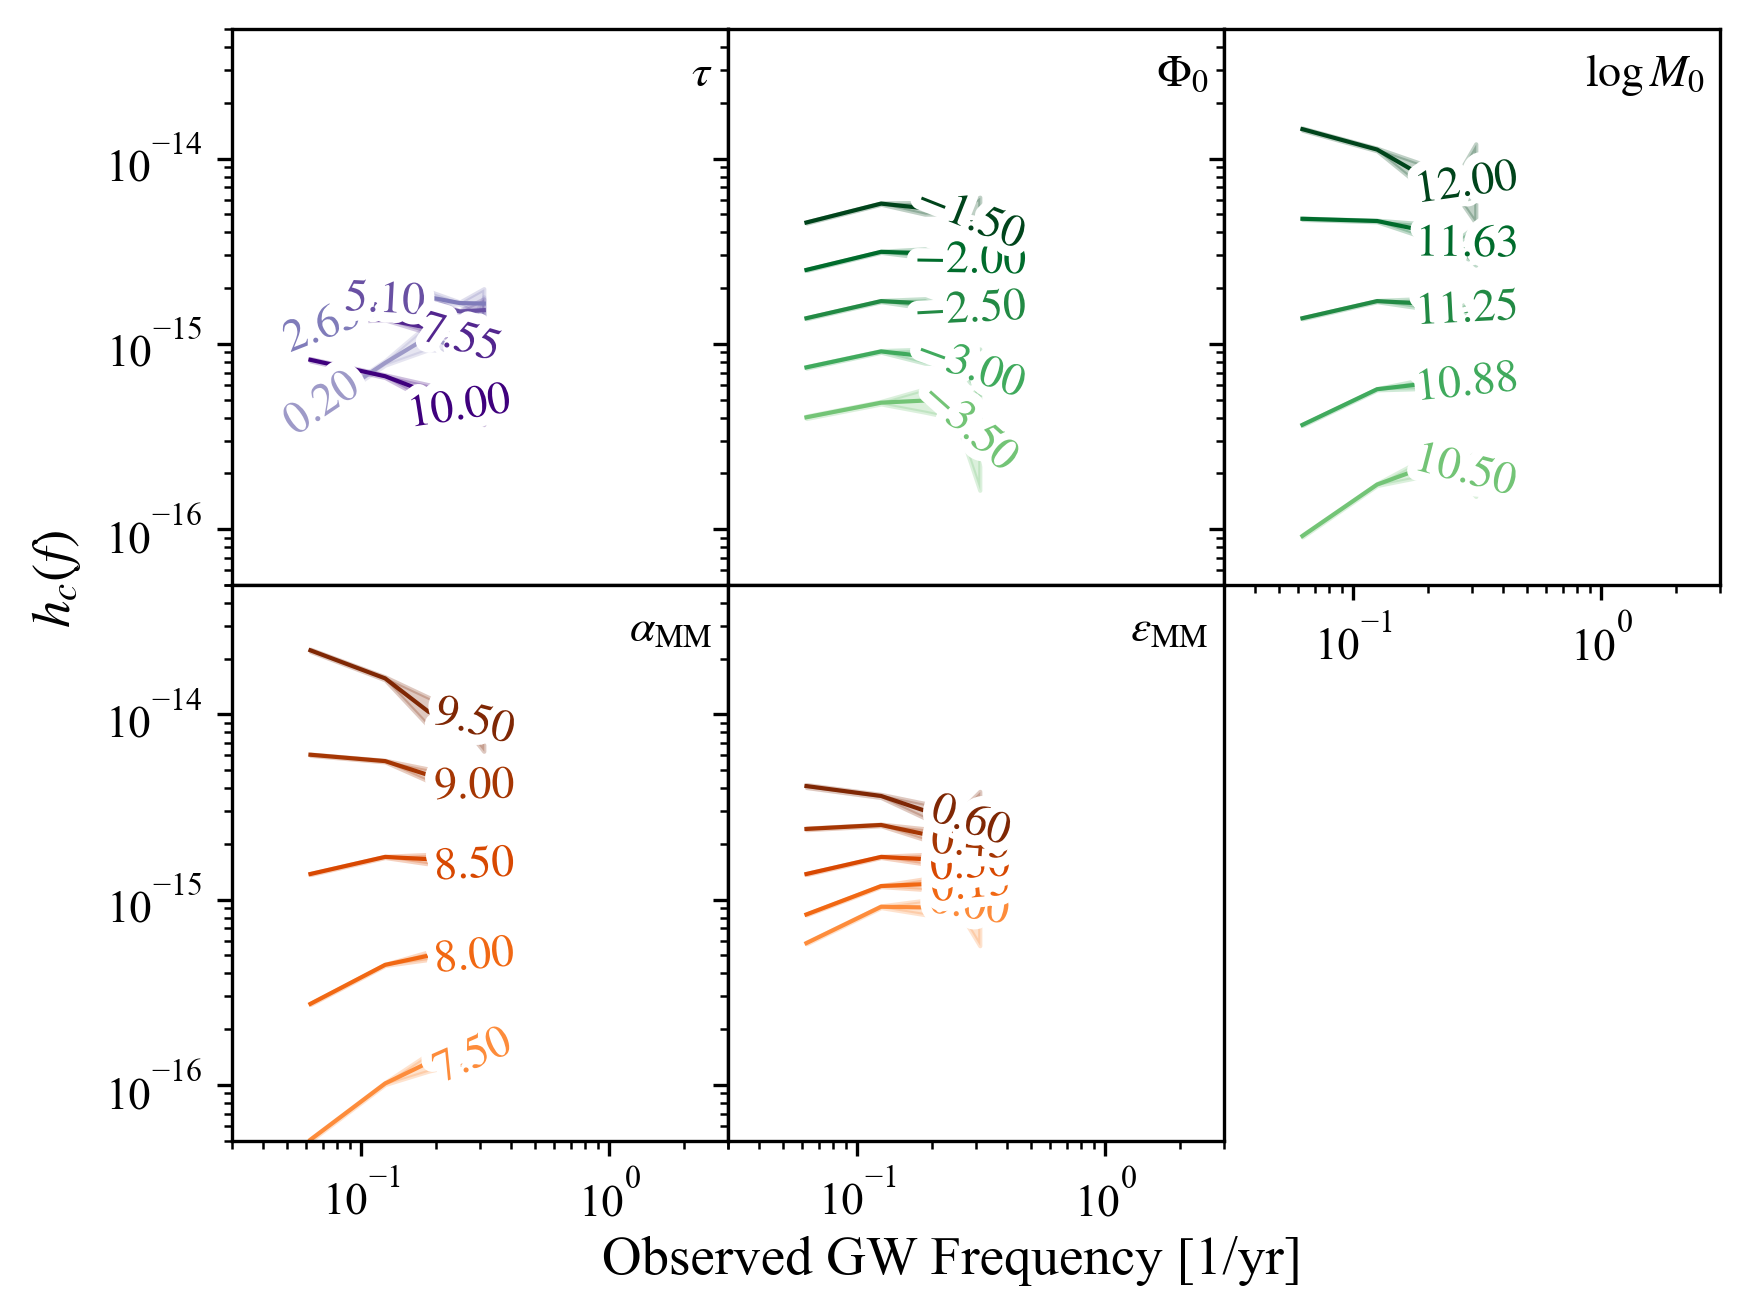

In [51]:
fig, axs = plt.subplots(2,3, sharex='all', sharey='all', figsize=(6.4, 6.4/1.33), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
fltaxs = axs.flatten()
for i, par_interest in enumerate(list(pars_linspace.keys())): # ['gsmf_phi0']): # 
    plt.sca(fltaxs[i])
    pu.pub_plot_individual_parameter(
        gp_george,
        gp,
        mean_pars,
        par_interest,
        spectra,
        find_sam_mean=False,
        model=sam_model.sam_for_params, # model_for_params, # 
        plot_dir="plots",
        nreal=10,
        num_points=5,
        multiprocessing=True,
        ax = fltaxs[i]
    )
fig.supxlabel('Observed GW Frequency [1/yr]')
fig.supylabel(r"$h_{c} (f)$")
fig.delaxes(fltaxs[5])
for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
# label_outer() should be smart enough to know if it is an outer axis and not just on the last row, but it isn't
fltaxs[2].xaxis.set_tick_params(which="major", labelbottom=True)
fname = f"plots/pub_param_varied_all.png"
fig.savefig(fname)

In [36]:
print(spectra["fobs"][:])

[1.97679899e-09 3.95359798e-09 5.93039697e-09 7.90719596e-09
 9.88399495e-09 1.18607939e-08 1.38375929e-08 1.58143919e-08
 1.77911909e-08 1.97679899e-08 2.17447889e-08 2.37215879e-08
 2.56983869e-08 2.76751859e-08 2.96519849e-08 3.16287838e-08
 3.36055828e-08 3.55823818e-08 3.75591808e-08 3.95359798e-08
 4.15127788e-08 4.34895778e-08 4.54663768e-08 4.74431758e-08
 4.94199748e-08 5.13967737e-08 5.33735727e-08 5.53503717e-08
 5.73271707e-08 5.93039697e-08 6.12807687e-08 6.32575677e-08
 6.52343667e-08 6.72111657e-08 6.91879647e-08 7.11647636e-08
 7.31415626e-08 7.51183616e-08 7.70951606e-08 7.90719596e-08]


### Getting back numerical values
`plotting_utils.plot_individual_parameter()` can optionally return numerical results

In [71]:
?pu.plot_individual_parameter

### Plotting all parameters
The following cell will plot GWBs for each paramter, shading the regions in between the extrema. Once again, the values held constant are specified by `mean_pars`, but you can supply your own.

Plot saved at /Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/notebooks/plots/params_varied.png


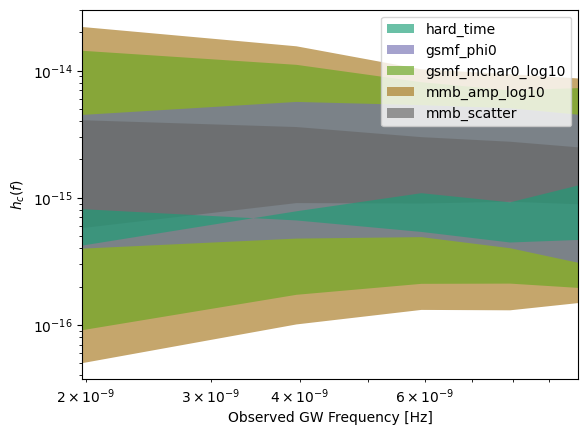

In [106]:
pu.plot_parameter_variances(
    gp_george, gp, mean_pars, spectra, alpha=0.65, plot_dir="plots"
)

### Plotting prediction over the data from the library
In the following cell, you can plot the GP's prediction on top of all of the realizations for a given parameter combination from the training data. If you reserved a training set, this would be a good place to choose an index that lies within the training set.

Found 4.00e+00/4.00e+03 = 1.00e-03 samples with NaN entries.  Removing them from library.
setting aside 0.0 of samples (0) for testing, and choosing 5 frequencies
         filter_window=2 filter_poly_order=1
Plot saved at /Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/notebooks/gp_overplotted.png
hard_time = 4.24E+00
gsmf_phi0 = -3.07E+00
gsmf_mchar0_log10 = 1.17E+01
mmb_amp_log10 = 7.62E+00
mmb_scatter = 3.92E-01


array([ 4.23900963, -3.07234395, 11.65585289,  7.6193025 ,  0.39188484])

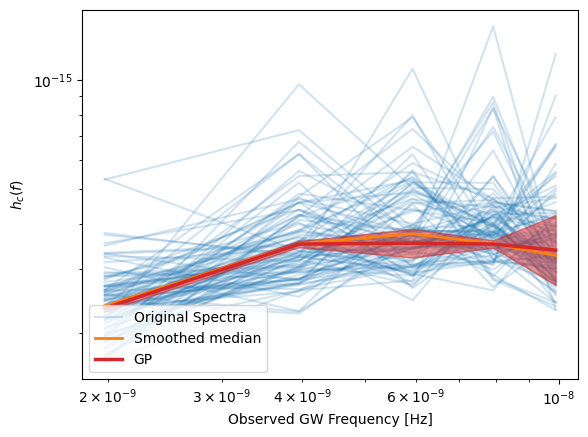

In [107]:
index = 300
pu.plot_over_realizations(index, spectra, gp_george, gp)

### Drawing from the emcee chain
Below, you'll see an example of drawing $h_\rm{c}(f)$ samples from the emcee chain. 

In [108]:
# Parameters from above plot
use_pars = [-4.95E-01, -6.01E-01, 2.13E+00, 1.57E+00, -2.03E+00, 8.48E+00]

# To use mean_pars, see below
#hc = gu.sample_hc_from_gp(gp_george, gp, list(mean_pars.values()), 100)


# I'm using the parameters from above because the spectra for the mean parameters are rather simple
hc = gu.sample_hc_from_gp(gp_george, gp, use_pars, 100)

ValueError: Dimension mismatch

In [ ]:
?gu.sample_hc_from_gp

In [ ]:
freqs = spectra["fobs"][: hc.shape[1]]
for i in range(hc.shape[0]):
    plt.loglog(freqs, hc[i, :], color="#4682b4", alpha=0.3)

plt.xlabel("Observed GW Frequency [Hz]")
plt.ylabel(r"$h_{c} (f)$")